In [ ]:
import re
import os
import numpy as np
import json

# Directorio donde están los archivos
directorio = os.path.join( "..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem', "0covo")

# Expresión regular para buscar la línea con la energía total
patron_energia = r'Total PSPW energy\s*:\s*(-?\d+\.\d+E[+-]\d+)'

# Listas para almacenar distancias y energías
distancias = []
energias = []

# Verificar si el directorio existe
if not os.path.exists(directorio):
    print(f"El directorio {directorio} no existe. Verifica la ruta.")
    exit()

# Buscar todos los archivos en el directorio
archivos = os.listdir(directorio)

# Procesar cada archivo
for archivo in archivos:
    # Filtrar solo archivos que terminen en .out y comiencen con H2-
    if not (archivo.endswith('.out') and archivo.startswith('H2-')):
        continue

    # Extraer la distancia del nombre del archivo (por ejemplo, H2-1.0.out -> 1.0)
    nombre = os.path.basename(archivo)
    try:
        distancia = float(nombre.replace('H2-', '').replace('.out', ''))
        print(f"Procesando archivo: {nombre}, Distancia: {distancia}")  # Para depurar
    except ValueError:
        print(f'No se pudo extraer la distancia de {nombre}. Saltando...')
        continue

    # Construir la ruta completa del archivo
    ruta_archivo = os.path.join(directorio, archivo)

    # Leer el archivo y buscar la energía
    try:
        with open(ruta_archivo, 'r') as f:
            for linea in f:
                coincidencia = re.search(patron_energia, linea)
                if coincidencia:
                    energia = float(coincidencia.group(1))
                    distancias.append(distancia)
                    energias.append(energia)
                    print(f'Archivo: {nombre}, Distancia: {distancia}, Energía: {energia} Hartree')
                    break
            else:
                print(f'No se encontró la energía en {nombre}.')
    except FileNotFoundError:
        print(f'El archivo {ruta_archivo} no se encuentra.')
    except Exception as e:
        print(f'Error procesando {nombre}: {e}')

# Convertir arrays de NumPy a listas para JSON
distancias = np.array(distancias)
energias = np.array(energias)
sorted_indices = np.argsort(distancias)
distancias = distancias[sorted_indices].tolist()  # Convertir a lista
energias = energias[sorted_indices].tolist()      # Convertir a lista

# Imprimir resultados
print('\nResultados finales:')
print('Distancias:', distancias)
print('Energías:', energias)

# Estructurar datos para JSON
datos_json = {
    "0covo": [
        distancias,
        energias
    ]
}
with open('results_PW_LiH_HF.json', 'w') as f:
    json.dump(datos_json, f, indent=4)  
    

In [47]:
import numpy as np
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC

import pyscf
from pyscf import mcscf, ao2mo, fci



geometries = ["""Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;""", 
             """Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;""",
             """Li 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """Li 0.0 0.0 -0.80; H 0.0 0.0 0.80;""",
             """Li 0.0 0.0 -0.85; H 0.0 0.0 0.85;""",
             """Li 0.0 0.0 -0.90; H 0.0 0.0 0.90;""",
             """Li 0.0 0.0 -0.95; H 0.0 0.0 0.95;""",
             """Li 0.0 0.0 -1.00; H 0.0 0.0 1.00;""",
             """Li 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """Li 0.0 0.0 -1.50; H 0.0 0.0 1.50;""",
             """Li 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """Li 0.0 0.0 -2.00; H 0.0 0.0 2.00;""",
             """Li 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """Li 0.0 0.0 -2.50; H 0.0 0.0 2.50;""",
             """Li 0.0 0.0 -3.00; H 0.0 0.0 3.00;""",
             """Li 0.0 0.0 -3.50; H 0.0 0.0 3.50;""",]#Angstrom

results_LiH = []

basis = "cc-pvdz"
cas = (4, 10) # active space
unit = "angstrom"  #angstrom, bohr

for i, geometry in enumerate(geometries):
    print(f"\nProcessing geometry {i+1}:")
    print(geometry)
    #### SlowQuant
    SQobj = sq.SlowQuant()
    SQobj.set_molecule(geometry, distance_unit=unit,)
    SQobj.set_basis_set(basis)

    #### PySCF
    mol = pyscf.M(atom = geometry, basis = basis, unit = unit)

    mf = mol.RHF().run()

    energy_HF = mf.e_tot

    #### HF 
    mo_coeffs = mf.mo_coeff #this has size (19,19)
    
    ## Control how many orbitals we wanna use in our calculations
    norb_act = 10
    mo_coeffs_act = mo_coeffs[:, :norb_act]
    
    #### get the integrals in the AO basis
    hcore_ao = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc')
    eri_4fold_ao = mol.intor('int2e_sph')
    
    hcore_ao_act = hcore_ao[:norb_act, :norb_act]
    eri_4fold_ao_act = eri_4fold_ao[:norb_act, :norb_act, :norb_act, :norb_act]

    # OO-UCCSD
    WF = WaveFunctionUCC(
    num_elec=SQobj.molecule.number_electrons,
    cas=cas,
    mo_coeffs=mo_coeffs,
    h_ao=hcore_ao,
    g_ao=eri_4fold_ao,
    excitations="SD",
    include_active_kappa=True,
    )
    
    WF.run_wf_optimization_1step(
    		optimizer_name="SLSQP", 
    		tol = 1e-6,
    		orbital_optimization=False)

    energy_uccsd = WF.energy_elec + mol.energy_nuc()

    fcisolver = fci.FCI(mf)
    energy_fci, fci_vector = fcisolver.kernel()
    
    norb_fci = fcisolver.norb
    print(f'Number of orbitals used in FCI: {norb_fci}')
    print(f"Hartree-Fock energy for geometry {i+1} = {energy_HF}")
    print(f"UCCSD energy for geometry {i+1} = {energy_uccsd}")
    print(f"FCI energy for geometry {i+1} = {energy_fci}")
      
    results_LiH.append({
        'geometry': geometry,
        'energy HF': energy_HF,
        'energy uccsd': energy_uccsd,
        'energy fci': energy_fci,
        'nuclear_repulsion': mol.energy_nuc(),
        'electronic_energy': WF.energy_elec
    })

with open('results_pvdz_LiH_4.json', 'w') as f:
    json.dump(results, f, indent=4)  



Processing geometry 1:
Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;
converged SCF energy = -7.96601167739468
### Parameters information:
### Number kappa: 0
### Number theta1: 16
### Number theta2: 136
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 152

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |        27.86       |     -9.1795986793101925    
Number of orbitals used in FCI: 19
Hartree-Fock energy for geometry 1 = -7.966011677394681
UCCSD energy for geometry 1 = -7.96828775605408
FCI energy for geometry 1 = -7.999100857546528

Processing geometry 2:
Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;
converged SCF energy = -7.97635394267362
### Parameters information:
### Number kappa: 0
### Number theta1: 16
### Number theta2: 136
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 152

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------   

TypeError: Object of type ndarray is not JSON serializable

In [1]:
import numpy as np
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
import matplotlib.pyplot as plt
import pyscf
from pyscf import mcscf, ao2mo, fci
#ccpvtz, ccpvqz

geometries = ["""Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;""", 
             """Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;""",
             """Li 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """Li 0.0 0.0 -0.80; H 0.0 0.0 0.80;""",
             """Li 0.0 0.0 -0.85; H 0.0 0.0 0.85;""",
             """Li 0.0 0.0 -0.90; H 0.0 0.0 0.90;""",
             """Li 0.0 0.0 -0.95; H 0.0 0.0 0.95;""",
             """Li 0.0 0.0 -1.00; H 0.0 0.0 1.00;""",
             """Li 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """Li 0.0 0.0 -1.50; H 0.0 0.0 1.50;""",
             """Li 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """Li 0.0 0.0 -2.00; H 0.0 0.0 2.00;""",
             """Li 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """Li 0.0 0.0 -2.50; H 0.0 0.0 2.50;""",
             """Li 0.0 0.0 -3.00; H 0.0 0.0 3.00;""",
             """Li 0.0 0.0 -3.50; H 0.0 0.0 3.50;""",]#Angstrom

distances = [1.3, 1.4, 1.5, 1.6, 1.7,1.8, 1.9, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0 ]  

basis = ["cc-pvdz", "cc-pvtz"]
results = {base: {} for base in basis}

unit= "angstroms"
for base in (basis):
    for i, geometry in enumerate(geometries):
       
        mol = pyscf.M(atom = geometry, basis = base, unit = unit)
        mf = mol.RHF().run()

        energy_HF = mf.e_tot

        fcisolver = fci.FCI(mf)
    
        energy_fci, fci_vector = fcisolver.kernel()
        norb_fci = fcisolver.norb

        distance = str(distances[i])  
        results[base][distance] = {
            "HF": energy_HF,
            "FCI": energy_fci,
            "N_orb": norb_fci
        }
        
        # Imprimir progreso (opcional)
        print(f"Base: {base}, Distance: {distance} Å, HF: {energy_HF:.8f}, FCI: {energy_fci:.8f}")

# Guardar resultados en archivo JSON
output_file = "energies_lih_atomic.json"
try:
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Resultados guardados exitosamente en {output_file}")
except Exception as e:
    print(f"Error al guardar el archivo JSON: {e}")

converged SCF energy = -7.96601167739468
Base: cc-pvdz, Distance: 1.3 Å, HF: -7.96601168, FCI: -7.99910086
converged SCF energy = -7.97635394267363
Base: cc-pvdz, Distance: 1.4 Å, HF: -7.97635394, FCI: -8.00828334
converged SCF energy = -7.98176766435951
Base: cc-pvdz, Distance: 1.5 Å, HF: -7.98176766, FCI: -8.01311056
converged SCF energy = -7.98364223163767
Base: cc-pvdz, Distance: 1.6 Å, HF: -7.98364223, FCI: -8.01474836
converged SCF energy = -7.98297651510812
Base: cc-pvdz, Distance: 1.7 Å, HF: -7.98297652, FCI: -8.01405673
converged SCF energy = -7.98049427699285
Base: cc-pvdz, Distance: 1.8 Å, HF: -7.98049428, FCI: -8.01169291
converged SCF energy = -7.97672349825131
Base: cc-pvdz, Distance: 1.9 Å, HF: -7.97672350, FCI: -8.00815718
converged SCF energy = -7.9720520404437
Base: cc-pvdz, Distance: 2.0 Å, HF: -7.97205204, FCI: -8.00382875
converged SCF energy = -7.9430166218121
Base: cc-pvdz, Distance: 2.5 Å, HF: -7.94301662, FCI: -7.97823779
converged SCF energy = -7.9138149656226

In [27]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
from pyscf import fci
import matplotlib.pyplot as plt
import numpy as np


covos = [1, 4, 8, 12, 18]

for covo in covos:
    print('{} COVOs'.format(covo))
    data_dir_nwchem = os.path.join("..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem','{}covo'.format(covo))
    data_dir_yaml = os.path.join("..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem', '{}covo_yaml'.format(covo))
    if not os.path.exists(data_dir_yaml):
        os.makedirs(os.path.join("..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem', '{}covo_yaml'.format(covo)))
    data_files = os.listdir(data_dir_nwchem)
    bond_distances = []

    for data_file in data_files:
        if data_file.find('out') == -1:
            continue
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        name = temp[0] + '-' + str(bond_distance)
        print("========= Bond distance: {} =========".format(bond_distance))
        data_file_yaml = os.path.join(data_dir_yaml, "{}.yaml".format(name))  # create the empty .yaml file in data_dir_yaml   
        
        data = extract_fields(os.path.join(data_dir_nwchem,data_file)) # data extracts the information from the output file 
        
        with open(data_file_yaml, 'w') as f:
            f.write(yaml.dump(data, default_flow_style=False)) # we write the extracted data into the .yaml file so we can work with it
            

1 COVOs
========= Bond distance: 4.0 =========
========= Bond distance: 1.3 =========
========= Bond distance: 7.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 1.6 =========
========= Bond distance: 1.7 =========
========= Bond distance: 3.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 1.9 =========
========= Bond distance: 5.0 =========
========= Bond distance: 1.5 =========
========= Bond distance: 1.4 =========
========= Bond distance: 4.5 =========
========= Bond distance: 6.0 =========
========= Bond distance: 3.5 =========
========= Bond distance: 1.8 =========
4 COVOs
========= Bond distance: 4.0 =========
========= Bond distance: 1.3 =========
========= Bond distance: 7.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 1.6 =========
========= Bond distance: 1.7 =========
========= Bond distance: 3.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 1.9 =========
=========

In [44]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
import pyscf
from pyscf import fci, mcscf, ao2mo
import matplotlib.pyplot as plt
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
from qiskit_nwchem_driver import customized_exp_kappa as kappa

# In this cell we run FCI and UCCSD for COVO. Computationally expensive for >12 COVO

fcisolver = fci.direct_spin1.FCI()

covos = [1,4,8,12,18]

data_covos={}
for covo in covos:
    print(f'{covo} COVOs')
    data_dir_yaml = os.path.join("..","data","PW_LiH_data", "3x3_aperiodic", 'NWChem', '{}covo_yaml'.format(covo))
    data_files = os.listdir(data_dir_yaml)
    bond_distances = []
    total_energies_uccsd = []
    total_energies_fci = []
    
    for data_file in data_files:
        if not data_file.endswith('.yaml'):
            continue
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        print(f"========= Bond distance: {bond_distance} =========")      
        yaml_file = os.path.join(data_dir_yaml, data_file)
        driver = nwchem_driver.NWchem_Driver(yaml_file)
        n_electrons, n_spatial_orbitals, nuclear_repulsion_energy, h1, h2 = driver.load_from_yaml(yaml_file, include_spin=False)

        WF = WaveFunctionUCC(
             num_elec=n_electrons,
             cas=(2,n_spatial_orbitals),
             mo_coeffs=np.identity(n_spatial_orbitals),
             #c_orthonormal = random_start_guess, 
             h_ao=h1,
             g_ao=h2,
             excitations="SD",
             include_active_kappa=True,
             )
        
       # WF.run_wf_optimization_1step(
       #      optimizer_name="SLSQP", 
       	#     tol = 1e-5,
       	#	 orbital_optimization=False)
        
        energy_fci, ci_vec = fcisolver.kernel(h1e=h1, eri=h2, norb=n_spatial_orbitals, nelec=2)      

        #total_energies_uccsd.append(WF.energy_elec + nuclear_repulsion_energy)
        total_energies_fci.append(energy_fci + nuclear_repulsion_energy)
        
        #print(f"UCCSD energy = {WF.energy_elec + nuclear_repulsion_energy}")
        print(f"FCI energy = {energy_fci  + nuclear_repulsion_energy}")
       
   # total_energies_uccsd = np.array(total_energies_uccsd)
    bond_distances = np.array(bond_distances)
    total_energies_fci = np.array(total_energies_fci)

    sorted_indices = np.argsort(bond_distances)
    bond_distances = bond_distances[sorted_indices]
    #total_energies_uccsd = total_energies_uccsd[sorted_indices]
    total_energies_fci = total_energies_fci[sorted_indices]
#total_energies_uccsd.tolist(),
    data_covos[covo] = [bond_distances.tolist(), total_energies_fci.tolist()]

with open('results_covo_LiH.json', 'w') as f:
     json.dump(data_covos, f, indent=4)  

1 COVOs
========= Bond distance: 2.5 =========
FCI energy = -0.7303973921169994
========= Bond distance: 1.8 =========
FCI energy = -0.7586034778918127
========= Bond distance: 3.0 =========
FCI energy = -0.7083890487805615
========= Bond distance: 1.5 =========
FCI energy = -0.7567063160144616
========= Bond distance: 1.3 =========
FCI energy = -0.7408700314270542
========= Bond distance: 4.5 =========
FCI energy = -0.6686650608395954
========= Bond distance: 6.0 =========
FCI energy = -0.6636550318300002
========= Bond distance: 1.7 =========
FCI energy = -0.7598994872237124
========= Bond distance: 4.0 =========
FCI energy = -0.6772150964366882
========= Bond distance: 7.0 =========
FCI energy = -0.6637155838400001
========= Bond distance: 3.5 =========
FCI energy = -0.6904653323625469
========= Bond distance: 5.0 =========
FCI energy = -0.6642378206228252
========= Bond distance: 1.4 =========
FCI energy = -0.7508555783836715
========= Bond distance: 1.9 =========
FCI energy = -0.7


Processing geometry 1:
Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;
converged SCF energy = -0.730186192525645

Processing geometry 2:
Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;
converged SCF energy = -0.739960394383232

Processing geometry 3:
Li 0.0 0.0 -0.75; H 0.0 0.0 0.75;
converged SCF energy = -0.745004210811525

Processing geometry 4:
Li 0.0 0.0 -0.80; H 0.0 0.0 0.80;
converged SCF energy = -0.746671118888502

Processing geometry 5:
Li 0.0 0.0 -0.85; H 0.0 0.0 0.85;
converged SCF energy = -0.745915722415368

Processing geometry 6:
Li 0.0 0.0 -0.90; H 0.0 0.0 0.90;
converged SCF energy = -0.743418644352296

Processing geometry 7:
Li 0.0 0.0 -0.95; H 0.0 0.0 0.95;
converged SCF energy = -0.739676259418304

Processing geometry 8:
Li 0.0 0.0 -1.00; H 0.0 0.0 1.00;
converged SCF energy = -0.73505625253416

Processing geometry 9:
Li 0.0 0.0 -1.25; H 0.0 0.0 1.25;
converged SCF energy = -0.70631475974318

Processing geometry 10:
Li 0.0 0.0 -1.50; H 0.0 0.0 1.50;
converged SCF energy = -0.677225787744618



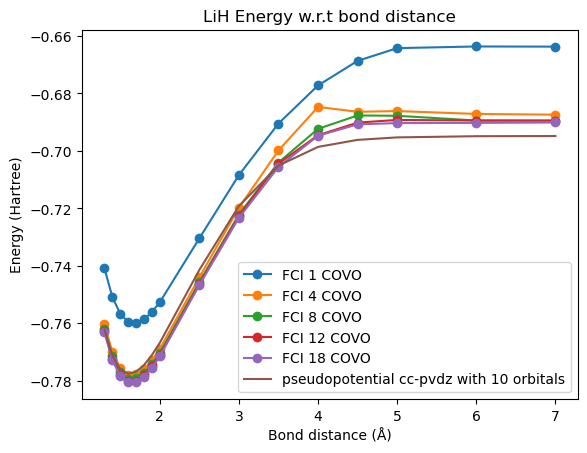

In [5]:
import pyscf
import numpy as np
import json
from pyscf import fci
from pyscf import mcscf, ao2mo, fci, scf
from pyscf import gto
import matplotlib.pyplot as plt
from pyscf.pbc import gto as pbcgto


geometries = ["""Li 0.0 0.0 -0.65; H 0.0 0.0 0.65;""", 
             """Li 0.0 0.0 -0.70; H 0.0 0.0 0.70;""",
             """Li 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """Li 0.0 0.0 -0.80; H 0.0 0.0 0.80;""",
             """Li 0.0 0.0 -0.85; H 0.0 0.0 0.85;""",
             """Li 0.0 0.0 -0.90; H 0.0 0.0 0.90;""",
             """Li 0.0 0.0 -0.95; H 0.0 0.0 0.95;""",
             """Li 0.0 0.0 -1.00; H 0.0 0.0 1.00;""",
             """Li 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """Li 0.0 0.0 -1.50; H 0.0 0.0 1.50;""",
             """Li 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """Li 0.0 0.0 -2.00; H 0.0 0.0 2.00;""",
             """Li 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """Li 0.0 0.0 -2.50; H 0.0 0.0 2.50;""",
             """Li 0.0 0.0 -3.00; H 0.0 0.0 3.00;""",
             """Li 0.0 0.0 -3.50; H 0.0 0.0 3.50;""",]#Angstrom

   
results= {}
basis = "cc-pvdz"
cas = (4, 10) # active space
unit = "angstrom"  #angstrom, bohr
n_orb_active = 11  

cell_size = 28.345889835 # en Å
a = np.eye(3) * cell_size  # Matriz de lattice (cúbica)

for i, geometry in enumerate(geometries):
    print(f"\nProcessing geometry {i+1}:")
    print(geometry)

    mol_pseudo = gto.M(atom=geometry, basis='cc-pvdz', unit='angstrom', pseudo='ccecp')

    mf_pseudo = mol_pseudo.RHF().run()

    mo_coeffs_pseudo = mf_pseudo.mo_coeff

    hcore_ao_pseudo = mol_pseudo.intor_symmetric('int1e_kin') + mol_pseudo.intor_symmetric('int1e_nuc')
    eri_4fold_ao_pseudo = mol_pseudo.intor('int2e_sph')

    mo_active = mo_coeffs_pseudo[:, :n_orb_active]
    hcore_mo_pseudo = np.einsum('pi,pq,qj->ij', mo_active, hcore_ao_pseudo, mo_active)
    eri_4fold_mo_pseudo = ao2mo.kernel(mol_pseudo, mo_active, aosym='s4')

    fcisolver = fci.FCI(mf_pseudo)
    energy_fci_pseudo, _ = fcisolver.kernel()
    
    results[i+1] = np.array([energy_fci_pseudo])

energies = [results[i][0] for i in range(1, len(geometries)+1)]  # Extrae energías


with open('results_covo_LiH.json', 'r') as f:
    energies_fci_covo_LiH = json.load(f)


for covo in energies_fci_covo_LiH:
    plt.plot(energies_fci_covo_LiH[covo][0], energies_fci_covo_LiH[covo][1], 'o-', label=f'FCI {covo} COVO')
plt.plot(energies_fci_covo_LiH[covo][0],energies, label='pseudopotential cc-pvdz with 10 orbitals')
plt.legend(loc=4)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('LiH Energy w.r.t bond distance')
#plt.ylim([-1.18,-0.8])
plt.savefig('LiH_COVO_pseudo.png')
plt.show()

In [1]:
import psi4

# Geometría de LiH
geometry = """
0 1
Li 0.0 0.0 -0.80
H  0.0 0.0  0.80
units angstrom
"""

# Definir pseudopotencial personalizado
ecp = {
    "Li": """
    Li ECP 2
    2 0 1.40000
    2 -9.4156269699 2
    2 -4.3831848418 2
    2 1 1.10000
    2 -3.3556427390 2
    2 -0.27652208407 2
    """
}

# Configurar la molécula
mol = psi4.geometry(geometry)
psi4.set_options({
    'basis': 'cc-pvdz',
    'ecp': ecp,
    'reference': 'rhf',
    'scf_type': 'pk'
})

# Cálculo RHF
rhf_energy, wfn = psi4.energy('scf', return_wfn=True)

# Cálculo FCI
fci_energy = psi4.energy('fci', ref_wfn=wfn)
print(f"Energía RHF: {rhf_energy:.6f} Hartree")
print(f"Energía FCI: {fci_energy:.6f} Hartree")

ModuleNotFoundError: No module named 'psi4'

In [ ]:
import json
#Load results UCCSD & FCI for COVO
with open('results_covo_H2.json', 'r') as f:
    energies_covo_H2 = json.load(f)
#Load results HF for PW
with open('results_PW_H2_HF.json', 'r') as f:
    energies_PW_H2_HF = json.load(f)
#Load results for FCI PW no COVO
with open('results_nocovo_H2_FCI.json', 'r') as f:
    energies_nocovo_H2_FCI = json.load(f)
#Load results HF & FCI for Atomic Orbitals
with open('energies_h2_atomic.json', 'r') as f:
    energies_h2_atomic = json.load(f)